<center> AR/S Correlation <center>

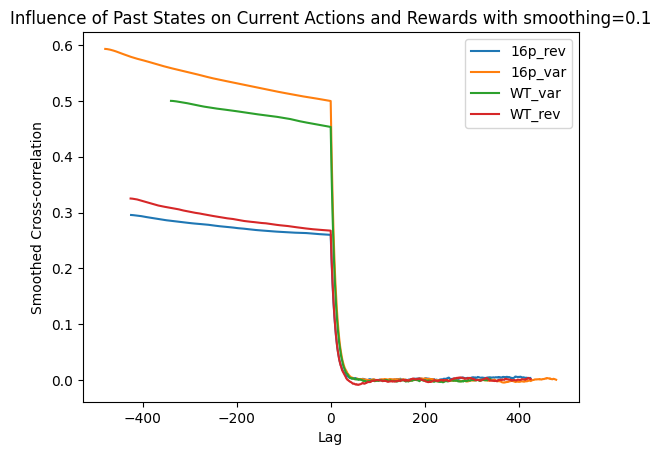

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# How current States influence future Actions and Rewards
# How past States influence current Actions and Rewards
def seq_states(link):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    S = df['tone_freq'].iloc[:].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
    results = []
    for t in range(len(S)):
        if S[t] == '6kHz':
            res = 1 
        elif S[t] == '10kHz':
            res = -1 
        results.append(res)
    return results

def seq_for_Actions_and_Rewards(link, c=1/2):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    rule = df['rule'].iloc[:].reset_index(drop=True)
    A = df['response'].iloc[:].reset_index(drop=True)
    R = df['rew_t'].iloc[:].reset_index(drop=True)
    results = []
    for t in range(len(A)):
        if A[t] == 'L' and R[t] == 1:
            res = 2 * c + c*rule[t]*(-4)
        elif A[t] == 'L' and R[t] == 0:
            res = 1 * c + c*rule[t]*(-2)
        elif A[t] == 'R' and R[t] == 0:
            res = -1 * c + c*rule[t]*(2)
        elif A[t] == 'R' and R[t] == 1:
            res = -2 * c + c*rule[t]*(4)
        else:
            res=0
        results.append(res)
    return results

def exponential_smoothing(data, alpha):
    smoothed = [data[0]]
    for i in range(1, len(data)):
        smoothed_value = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(smoothed_value)
    return smoothed

def cross_correlation(seq1, seq2, max_lag, alpha):
    correlations = []
    for lag in range(-max_lag, max_lag + 1):
        if lag > 0:
            seq1_lagged = np.pad(seq1, (lag, 0), 'constant')[:len(seq1)]
            seq2_lagged = seq2[:len(seq1) - lag]
        elif lag < 0:
            seq1_lagged = seq1[:len(seq1) + lag]
            seq2_lagged = np.pad(seq2, (abs(lag), 0), 'constant')[:len(seq2)]
        else:
            seq1_lagged = seq1
            seq2_lagged = seq2

        correlation = np.correlate(seq1_lagged, seq2_lagged)[0] / (len(seq1_lagged) - abs(lag))
        correlations.append(correlation)
    
    smoothed_correlations = exponential_smoothing(correlations, alpha)
    
    return smoothed_correlations

df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')


# Ensure column names are correct
links_16p_rev = df['link_16p_rev'].dropna().tolist()
links_16p_var = df['link_16p_var'].dropna().tolist()
links_WT_rev = df['link_WT_rev'].dropna().tolist()
links_WT_var = df['link_WT_var'].dropna().tolist()

def max_lag_per_mouseType(links):
    lengths = []
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        R = df['rew_t'].iloc[:].reset_index(drop=True)
        lengths.append(len(R))
    max_lag = int(0.2*min(lengths))
    return max_lag

lag_16p_rev = max_lag_per_mouseType(links_16p_rev)
lag_16p_var = max_lag_per_mouseType(links_16p_var)
lag_WT_rev = max_lag_per_mouseType(links_WT_rev)
lag_WT_var = max_lag_per_mouseType(links_WT_var)

def compute_mean_correlations(links, max_lag, alpha):
    sum_correlations = np.zeros(2 * max_lag + 1)
    count = len(links)
    
    for link in links:
        seq1 = seq_for_Actions_and_Rewards(link, c=1/2)
        seq2 = seq_states(link)
        correlations = cross_correlation(seq1, seq2, max_lag, alpha)
        sum_correlations += correlations

    mean_correlations = sum_correlations / count
    return mean_correlations
alpha = 0.1
mean_correlations_16p_rev = compute_mean_correlations(links_16p_rev, lag_16p_rev,alpha)
mean_correlations_16p_var = compute_mean_correlations(links_16p_var, lag_16p_var, alpha)
mean_correlations_WT_var = compute_mean_correlations(links_WT_var, lag_WT_var, alpha)
mean_correlations_WT_rev = compute_mean_correlations(links_WT_rev, lag_WT_rev, alpha)

# Plot
lags_16p_rev = list(range(-lag_16p_rev, lag_16p_rev + 1))
lags_16p_var = list(range(-lag_16p_var, lag_16p_var + 1))
lags_WT_var = list(range(-lag_WT_var, lag_WT_var + 1))
lags_WT_rev = list(range(-lag_WT_rev, lag_WT_rev + 1))

plt.plot(lags_16p_rev, mean_correlations_16p_rev, label='16p_rev')
plt.plot(lags_16p_var, mean_correlations_16p_var, label='16p_var')
plt.plot(lags_WT_var, mean_correlations_WT_var, label='WT_var')
plt.plot(lags_WT_rev, mean_correlations_WT_rev, label='WT_rev')
plt.xlabel('Lag')
plt.ylabel('Smoothed Cross-correlation')
plt.title(f'Influence of Past States on Current Actions and Rewards with smoothing={alpha}')
plt.legend()
plt.show()


<center>  A/SR Correlation  <center>

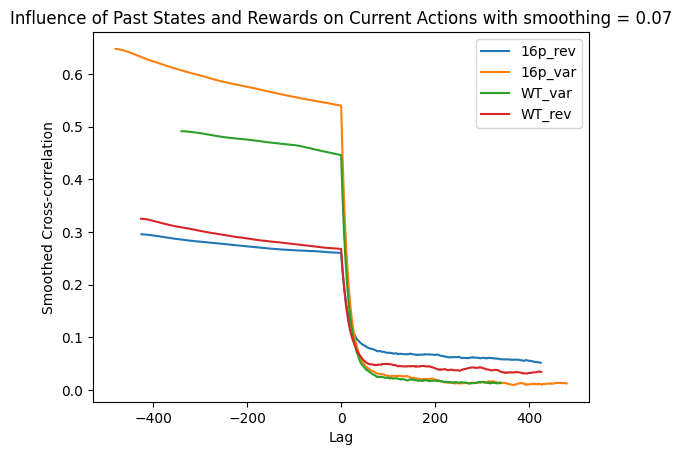

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#How Current Actions are influenced by Past Rewards and States
# How Future Actions are influenced by Current Rewards and States
def seq_actions(link):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    A = df['response'].iloc[:].reset_index(drop=True)
    rule = df['rule'].iloc[:].reset_index(drop=True)
    results = []
    for t in range(len(A)):
        if A[t] == 'L':
            res = 1 + rule[t] * (-2)
        elif A[t] == 'R':
            res = -1 + rule[t] * (2)
        else:
            res = 0
        results.append(res)
    return results

def seq_for_States_and_Rewards(link, c=1/2):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    S = df['tone_freq'].iloc[:].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
    R = df['rew_t'].iloc[:].reset_index(drop=True)
    results = []
    for t in range(len(S)):
        if S[t] == '6kHz' and R[t] == 1:
            res = 2 * c
        elif S[t] == '6kHz' and R[t] == 0:
            res = 1 * c
        elif S[t] == '10kHz' and R[t] == 0:
            res = -1 * c
        elif S[t] == '10kHz' and R[t] == 1:
            res = -2 * c
        results.append(res)
    return results

def exponential_smoothing(data, alpha):
    smoothed = [data[0]]
    for i in range(1, len(data)):
        smoothed_value = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(smoothed_value)
    return smoothed

def cross_correlation(seq1, seq2, max_lag, alpha):
    correlations = []
    for lag in range(-max_lag, max_lag + 1):
        if lag > 0:
            seq1_lagged = np.pad(seq1, (lag, 0), 'constant')[:len(seq1)]
            seq2_lagged = seq2[:len(seq1) - lag]
        elif lag < 0:
            seq1_lagged = seq1[:len(seq1) + lag]
            seq2_lagged = np.pad(seq2, (abs(lag), 0), 'constant')[:len(seq2)]
        else:
            seq1_lagged = seq1
            seq2_lagged = seq2

        correlation = np.correlate(seq1_lagged, seq2_lagged)[0] / (len(seq1_lagged) - abs(lag))
        correlations.append(correlation)
    
    smoothed_correlations = exponential_smoothing(correlations, alpha)
    
    return smoothed_correlations

df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')


# Ensure column names are correct
links_16p_rev = df['link_16p_rev'].iloc[:5].dropna().tolist()
links_16p_var = df['link_16p_var'].iloc[:5].dropna().tolist()
links_WT_rev = df['link_WT_rev'].iloc[:5].dropna().tolist()
links_WT_var = df['link_WT_var'].iloc[:5].dropna().tolist()

def max_lag_per_mouseType(links):
    lengths = []
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        R = df['rew_t'].iloc[:].reset_index(drop=True)
        lengths.append(len(R))
    max_lag = int(0.2 * min(lengths))
    return max_lag

lag_16p_rev = max_lag_per_mouseType(links_16p_rev)
lag_16p_var = max_lag_per_mouseType(links_16p_var)
lag_WT_rev = max_lag_per_mouseType(links_WT_rev)
lag_WT_var = max_lag_per_mouseType(links_WT_var)

def compute_mean_correlations(links, max_lag, alpha):
    sum_correlations = np.zeros(2 * max_lag + 1)
    count = len(links)
    
    for link in links:
        seq1 = seq_actions(link)
        seq2 = seq_for_States_and_Rewards(link, c=1/2)
        correlations = cross_correlation(seq1, seq2, max_lag, alpha)
        sum_correlations += correlations

    mean_correlations = sum_correlations / count
    return mean_correlations
alpha = 0.07
mean_correlations_16p_rev = compute_mean_correlations(links_16p_rev, lag_16p_rev, alpha)
mean_correlations_16p_var = compute_mean_correlations(links_16p_var, lag_16p_var, alpha)
mean_correlations_WT_var = compute_mean_correlations(links_WT_var, lag_WT_var, alpha)
mean_correlations_WT_rev = compute_mean_correlations(links_WT_rev, lag_WT_rev, alpha)

# Plot
lags_16p_rev = list(range(-lag_16p_rev, lag_16p_rev + 1))
lags_16p_var = list(range(-lag_16p_var, lag_16p_var + 1))
lags_WT_var = list(range(-lag_WT_var, lag_WT_var + 1))
lags_WT_rev = list(range(-lag_WT_rev, lag_WT_rev + 1))


plt.plot(lags_16p_rev, mean_correlations_16p_rev, label='16p_rev')
plt.plot(lags_16p_var, mean_correlations_16p_var, label='16p_var')
plt.plot(lags_WT_var, mean_correlations_WT_var, label='WT_var')
plt.plot(lags_WT_rev, mean_correlations_WT_rev, label='WT_rev')
plt.xlabel('Lag')
plt.ylabel('Smoothed Cross-correlation')
plt.title(f'Influence of Past States and Rewards on Current Actions with smoothing = {alpha}')
plt.legend()
plt.show()


<center> SA/R Correlation<center>

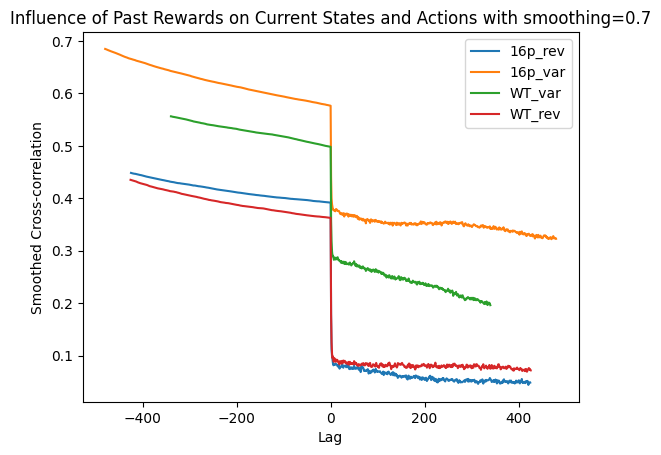

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# How Current Rewards affect future States and Actions
# How Past Rewards affect current States and Actions
def seq_Actions_and_States(link):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    A = df['response'].iloc[:].reset_index(drop=True)
    S = df['tone_freq'].iloc[:].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
    rule = df['rule'].iloc[:].reset_index(drop=True)
    results = []
    for t in range(len(A)):
        if ((A[t] == 'L') and (S[t]=='6kHz')) or ((A[t] == 'R') and (S[t]=='10kHz')):
            res = 1 +  rule[t] * (-2)
        elif ((A[t] == 'R') and (S[t]=='6kHz')) or ((A[t] == 'L') and (S[t]=='10kHz')):
            res = -1 + rule[t] * (2)
        else:
            res = 0
        results.append(res)
    return results

def seq_Rewards(link):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    R = df['rew_t'].iloc[:].reset_index(drop=True)
    results = []
    for t in range(len(R)):
        if R[t]:
            res=1
        else:
            res=0
        results.append(res)
    return results

def exponential_smoothing(data, alpha):
    smoothed = [data[0]]
    for i in range(1, len(data)):
        smoothed_value = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(smoothed_value)
    return smoothed

def cross_correlation(seq1, seq2, max_lag, alpha):
    correlations = []
    for lag in range(-max_lag, max_lag + 1):
        if lag > 0:
            seq1_lagged = np.pad(seq1, (lag, 0), 'constant')[:len(seq1)]
            seq2_lagged = seq2[:len(seq1) - lag]
        elif lag < 0:
            seq1_lagged = seq1[:len(seq1) + lag]
            seq2_lagged = np.pad(seq2, (abs(lag), 0), 'constant')[:len(seq2)]
        else:
            seq1_lagged = seq1
            seq2_lagged = seq2

        correlation = np.correlate(seq1_lagged, seq2_lagged)[0] / (len(seq1_lagged) - abs(lag))
        correlations.append(correlation)
    
    smoothed_correlations = exponential_smoothing(correlations, alpha)
    
    return smoothed_correlations

df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')


# Ensure column names are correct
links_16p_rev = df['link_16p_rev'].iloc[:5].dropna().tolist()
links_16p_var = df['link_16p_var'].iloc[:5].dropna().tolist()
links_WT_rev = df['link_WT_rev'].iloc[:5].dropna().tolist()
links_WT_var = df['link_WT_var'].iloc[:5].dropna().tolist()

def max_lag_per_mouseType(links):
    lengths = []
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        R = df['rew_t'].iloc[:].reset_index(drop=True)
        lengths.append(len(R))
    max_lag = int(0.2 * min(lengths))
    return max_lag

lag_16p_rev = max_lag_per_mouseType(links_16p_rev)
lag_16p_var = max_lag_per_mouseType(links_16p_var)
lag_WT_rev = max_lag_per_mouseType(links_WT_rev)
lag_WT_var = max_lag_per_mouseType(links_WT_var)

def compute_mean_correlations(links, max_lag, alpha):
    sum_correlations = np.zeros(2 * max_lag + 1)
    count = len(links)
    
    for link in links:
        seq1 = seq_Actions_and_States(link)
        seq2 = seq_Rewards(link)
        correlations = cross_correlation(seq1, seq2, max_lag, alpha)
        sum_correlations += correlations

    mean_correlations = sum_correlations / count
    return mean_correlations
alpha = 0.7
mean_correlations_16p_rev = compute_mean_correlations(links_16p_rev, lag_16p_rev, alpha)
mean_correlations_16p_var = compute_mean_correlations(links_16p_var, lag_16p_var, alpha)
mean_correlations_WT_var = compute_mean_correlations(links_WT_var, lag_WT_var, alpha)
mean_correlations_WT_rev = compute_mean_correlations(links_WT_rev, lag_WT_rev, alpha)

# Plot
lags_16p_rev = list(range(-lag_16p_rev, lag_16p_rev + 1))
lags_16p_var = list(range(-lag_16p_var, lag_16p_var + 1))
lags_WT_var = list(range(-lag_WT_var, lag_WT_var + 1))
lags_WT_rev = list(range(-lag_WT_rev, lag_WT_rev + 1))


plt.plot(lags_16p_rev, mean_correlations_16p_rev, label='16p_rev')
plt.plot(lags_16p_var, mean_correlations_16p_var, label='16p_var')
plt.plot(lags_WT_var, mean_correlations_WT_var, label='WT_var')
plt.plot(lags_WT_rev, mean_correlations_WT_rev, label='WT_rev')
plt.xlabel('Lag')
plt.ylabel('Smoothed Cross-correlation')
plt.title(f'Influence of Past Rewards on Current States and Actions with smoothing={alpha}')
plt.legend()
plt.show()

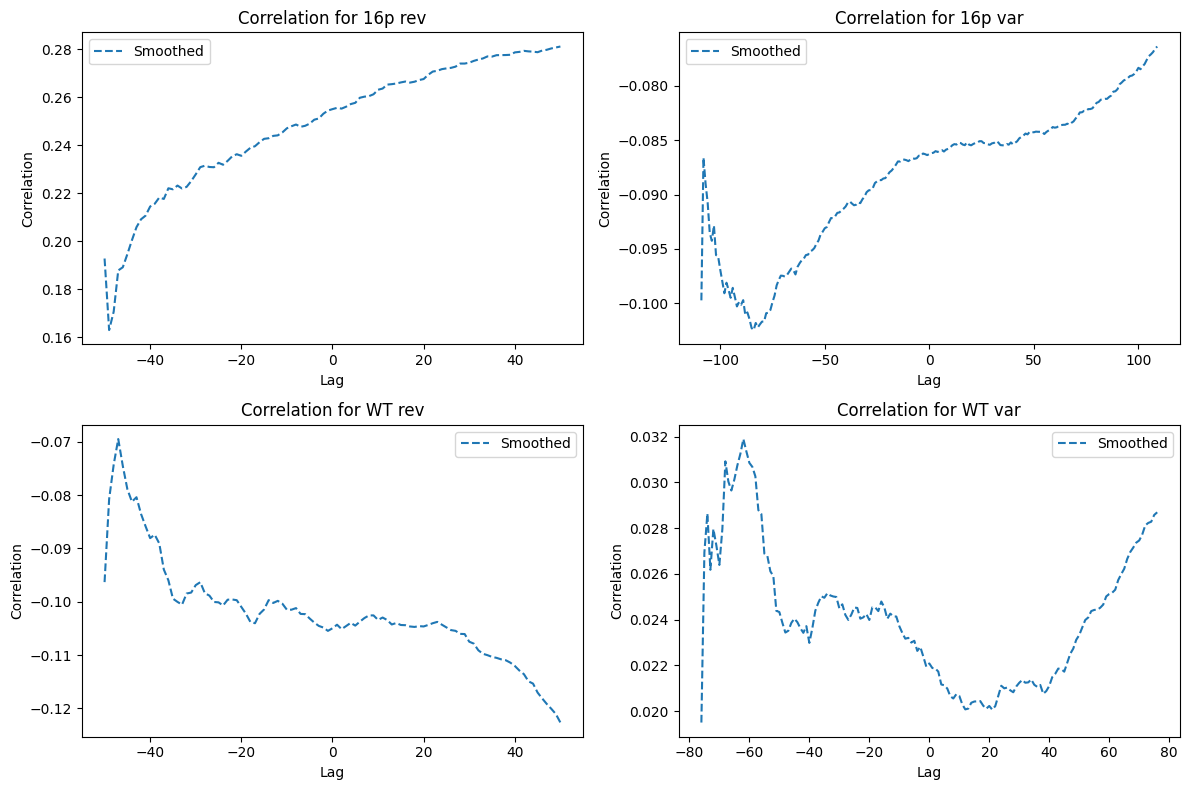

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import correlate

# Load the Excel file
df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')

# Ensure column names are correct
links_16p_rev = df['link_16p_rev'].iloc[:5].dropna().tolist()
links_16p_var = df['link_16p_var'].iloc[:5].dropna().tolist()
links_WT_rev = df['link_WT_rev'].iloc[:5].dropna().tolist()
links_WT_var = df['link_WT_var'].iloc[:5].dropna().tolist()

def find_expert_segments(expert_series, choice):
    expert_segments = []
    in_segment = False
    segment_start = None
    
    for i, value in enumerate(expert_series):
        if value and not in_segment:
            in_segment = True
            segment_start = i
        elif not value and in_segment:
            in_segment = False
            expert_segments.append([segment_start, i - 1])
            segment_start = None

    if in_segment:
        expert_segments.append([segment_start, len(expert_series) - 1])
    
    if choice == 1 and expert_segments:
        expert_segments = [expert_segments[0]]
    
    return expert_segments

def max_lag_per_mouseType(links, choice):
    dic = {}
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        expert_series = df['expert'].reset_index(drop=True)
        expert_segments = find_expert_segments(expert_series, choice)
        dic[link] = expert_segments
    return dic

choice = int(input("Enter 1 to extract only one expert phase, or 2 to allow multiple expert phases: ").strip())

Expert_16p_rev = max_lag_per_mouseType(links_16p_rev, choice)
Expert_16p_var = max_lag_per_mouseType(links_16p_var, choice)
Expert_WT_rev = max_lag_per_mouseType(links_WT_rev, choice)
Expert_WT_var = max_lag_per_mouseType(links_WT_var, choice)

def SAR_Generator(mouse_type_links, choice):
    Expert_mouse_type = max_lag_per_mouseType(mouse_type_links, choice)
    sar_dict = {link: {'states': [], 'actions': [], 'rewards': []} for link in mouse_type_links}

    for link in mouse_type_links:
        start_link, end_link = Expert_mouse_type[link][0]
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        
        S = df['tone_freq'].iloc[start_link:end_link+1].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
        A = df['response'].iloc[start_link:end_link+1].reset_index(drop=True)
        R = df['rew_t'].iloc[start_link:end_link+1].reset_index(drop=True)
        
        sar_dict[link]['states'].extend(S)
        sar_dict[link]['actions'].extend(A)
        sar_dict[link]['rewards'].extend(R)

    return sar_dict

def AR_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_AR = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        actions = dic_mouse_type[link]['actions']
        rewards = dic_mouse_type[link]['rewards']
        Y = []
        for i in range(len(actions)):
            if actions[i] == 'L' and rewards[i] == 1:
                Y_i = 2
            elif actions[i] == 'L' and rewards[i] == 0:
                Y_i = 1
            elif actions[i] == 'R' and rewards[i] == 0:
                Y_i = -1
            elif actions[i] == 'R' and rewards[i] == 1:
                Y_i = -2
            elif actions[i] == 'N':
                Y_i = 0
            Y.append(Y_i)
        DIC_AR[link].extend(Y)
    return DIC_AR

def S_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_S = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        states = dic_mouse_type[link]['states']
        X = []
        for i in range(len(states)):
            if states[i] == '6kHz':
                X_i = 1
            elif states[i] == '10kHz':
                X_i = -1
            X.append(X_i)
        DIC_S[link].extend(X)
    return DIC_S

def SA_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_SA = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        states = dic_mouse_type[link]['states']
        actions = dic_mouse_type[link]['actions']
        X = []
        for i in range(len(states)):
            if (states[i] == '6kHz' and actions[i] == 'L') or (states[i] == '10kHz' and actions[i] == 'R'):
                X_i = 1
            elif (states[i] == '6kHz' and actions[i] == 'R') or (states[i] == '10kHz' and actions[i] == 'L'):
                X_i = -1
            else:
                X_i = 0
            X.append(X_i)
        DIC_SA[link].extend(X)
    return DIC_SA

def A_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_A = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        actions = dic_mouse_type[link]['actions']
        Y = []
        for i in range(len(actions)):
            if actions[i] == 'L':
                Y_i = 1
            elif actions[i] == 'R':
                Y_i = -1
            else:
                Y_i = 0
            Y.append(Y_i)
        DIC_A[link].extend(Y)
    return DIC_A

def R_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_R = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        rewards = dic_mouse_type[link]['rewards']
        X = []
        for i in range(len(rewards)):
            if rewards[i] == 1:
                X_i = 1
            else:
                X_i = 0
            X.append(X_i)
        DIC_R[link].extend(X)
    return DIC_R

def min_expert_length(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    lengths = []
    for link in mouse_type_links:
        rewards = dic_mouse_type[link]['rewards']
        lengths.append(len(rewards))
    max_lag = int(0.2 * min(lengths))
    return max_lag

def avg_correlate(mouse_type_links, choice):
    #correlator : A(t-tau)R(t)
    max_lag = min_expert_length(mouse_type_links, choice)
    total_corr = None
    num_links = len(mouse_type_links)
    
    for link in mouse_type_links:
        X = R_mapping(mouse_type_links, choice)[link]
        Y = A_mapping(mouse_type_links, choice)[link]
        
        R_seq = np.array(X)
        A_seq = np.array(Y)
        
        if len(R_seq) != len(A_seq):
            min_length = min(len(R_seq), len(A_seq))
            R_seq = R_seq[:min_length]
            A_seq = A_seq[:min_length]
        
        corr = correlate(A_seq, R_seq, mode='full')/(np.std(R_seq)*np.std(A_seq)*len(R_seq))
        #correlation : norm(sum(A(t-tau)R(t)))
        mid = len(corr) // 2
        corr = corr[mid - max_lag : mid + max_lag + 1]
        
        if total_corr is None:
            total_corr = corr
        else:
            total_corr += corr
    
    avg_corr = total_corr / num_links   

    lags = np.arange(-max_lag, max_lag + 1)
    return avg_corr, lags

def exponential_smoothing(series, alpha=0.3):
    return series.ewm(alpha=alpha).mean()

# Plotting
y_16p_rev, x_16p_rev = avg_correlate(links_16p_rev, choice)
y_16p_var, x_16p_var = avg_correlate(links_16p_var, choice)
y_WT_rev, x_WT_rev = avg_correlate(links_WT_rev, choice)
y_WT_var, x_WT_var = avg_correlate(links_WT_var, choice)

# Apply exponential smoothing
alpha = 0.01  # Smoothing factor, can be adjusted
y_16p_rev_smoothed = exponential_smoothing(pd.Series(y_16p_rev), alpha).values
y_16p_var_smoothed = exponential_smoothing(pd.Series(y_16p_var), alpha).values
y_WT_rev_smoothed = exponential_smoothing(pd.Series(y_WT_rev), alpha).values
y_WT_var_smoothed = exponential_smoothing(pd.Series(y_WT_var), alpha).values

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
#plt.plot(x_16p_rev, y_16p_rev, label='Original')
plt.plot(x_16p_rev, y_16p_rev_smoothed, label='Smoothed', linestyle='--')
plt.title('Correlation for 16p rev')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 2)
#plt.plot(x_16p_var, y_16p_var, label='Original')
plt.plot(x_16p_var, y_16p_var_smoothed, label='Smoothed', linestyle='--')
plt.title('Correlation for 16p var')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 3)
#plt.plot(x_WT_rev, y_WT_rev, label='Original')
plt.plot(x_WT_rev, y_WT_rev_smoothed, label='Smoothed', linestyle='--')
plt.title('Correlation for WT rev')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 4)
#plt.plot(x_WT_var, y_WT_var, label='Original')
plt.plot(x_WT_var, y_WT_var_smoothed, label='Smoothed', linestyle='--')
plt.title('Correlation for WT var')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.tight_layout()
plt.show()